# Superstore Sales Dataset

## Context
Retail dataset of a global superstore for 4 years.

## Source
The dataset is from Kaggle and can be found on https://www.kaggle.com/rohitsahoo/sales-forecasting.

## Description		
| Variable | Description |
| :- | :- |

In [1]:
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")

## Data Import

In [74]:
path = r"data\train.csv"
df = pd.read_csv(path, encoding = "ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


## Initial EDA

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

Only the column "Postal Code" contains a missing value. Let's later decide whether to drop this one row or to impute it using the country and the state column.

Now, the pandas function "describe" is called. This is always nice to get the first insights into the numerical features and their value ranges and some statistics.

In [78]:
df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


Seems like Row ID column is only containing unique values. Let's check that and drop them in case that's true, because columns with only unique values are not delivering any usefull features for machine learning.

In [79]:
for col in df.columns:
    print(f"Column {col} contains {len(df[col].unique())} unique values ({ 100 * len(df[col].unique()) / df.shape[0]}% of total data).")

Column Row ID contains 9800 unique values (100.0% of total data).
Column Order ID contains 4922 unique values (50.224489795918366% of total data).
Column Order Date contains 1230 unique values (12.551020408163266% of total data).
Column Ship Date contains 1326 unique values (13.53061224489796% of total data).
Column Ship Mode contains 4 unique values (0.04081632653061224% of total data).
Column Customer ID contains 793 unique values (8.091836734693878% of total data).
Column Customer Name contains 793 unique values (8.091836734693878% of total data).
Column Segment contains 3 unique values (0.030612244897959183% of total data).
Column Country contains 1 unique values (0.01020408163265306% of total data).
Column City contains 529 unique values (5.3979591836734695% of total data).
Column State contains 49 unique values (0.5% of total data).
Column Postal Code contains 627 unique values (6.3979591836734695% of total data).
Column Region contains 4 unique values (0.04081632653061224% of to

Okay. The columns "Row ID" can be dropped. In addition, the column "Order ID" is also containing a lot of unique values. Let's later investigate this feature further. Furthermore, the feature "Country" can also be dropped, because it is always the same value and therefore not helpful for the model later on.

In [102]:
df_changed = df.drop(columns=["Row ID", "Country"])
df_changed.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [103]:
df_changed['Order Date'] =  pd.to_datetime(df_changed['Order Date'], format='%d/%m/%Y')
df_changed['Ship Date'] =  pd.to_datetime(df_changed['Ship Date'], format='%d/%m/%Y')

In [104]:
df_changed.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [105]:
df_changed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9800 non-null   object        
 1   Order Date     9800 non-null   datetime64[ns]
 2   Ship Date      9800 non-null   datetime64[ns]
 3   Ship Mode      9800 non-null   object        
 4   Customer ID    9800 non-null   object        
 5   Customer Name  9800 non-null   object        
 6   Segment        9800 non-null   object        
 7   City           9800 non-null   object        
 8   State          9800 non-null   object        
 9   Postal Code    9789 non-null   float64       
 10  Region         9800 non-null   object        
 11  Product ID     9800 non-null   object        
 12  Category       9800 non-null   object        
 13  Sub-Category   9800 non-null   object        
 14  Product Name   9800 non-null   object        
 15  Sales          9800 n

Start with more detailed EDA. <br> <br>
Let's first plot a histogram of the Sales data.

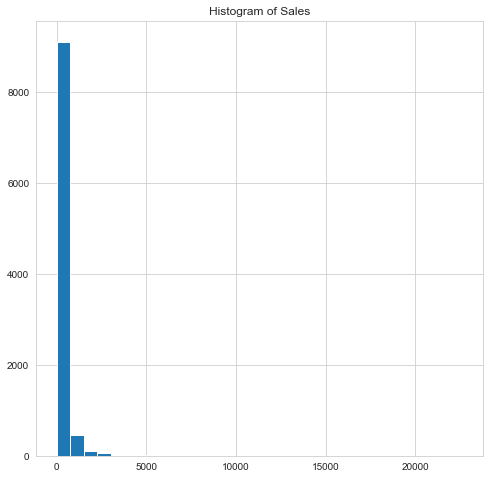

In [106]:
plt.title(f"Histogram of Sales")
plt.hist(df_changed["Sales"], bins=30)
plt.show()

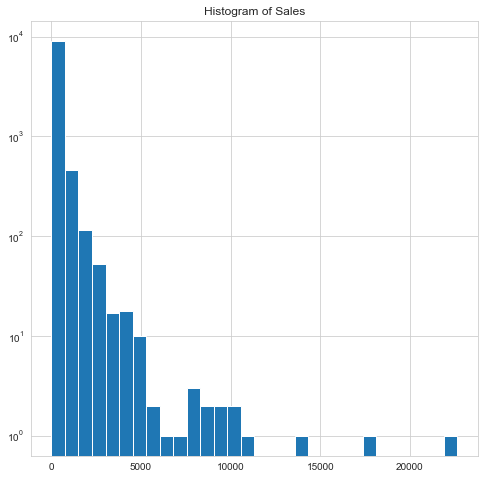

In [107]:
plt.title(f"Histogram of Sales")
plt.hist(df_changed["Sales"], bins=30)
plt.yscale("log")
plt.show()

The sales target value is left skewed. This could lead to problems in correctly predicting the target sales data. Let's later investigate some skewness correction techniques. <br> <br>
Let's now create a list of all categorical features and let's check how many categories each categorical feature has. Then as a next step, the categorical features are visualized and pre-processed, if required.

In [108]:
cat_features = df_changed.columns[df_changed.dtypes == np.object].to_list()
cat_features

['Order ID',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'City',
 'State',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name']

In [109]:
for cat_feature in cat_features:
    print(df_changed[cat_feature].value_counts())

CA-2018-100111    14
CA-2018-157987    12
CA-2017-165330    11
US-2017-108504    11
CA-2017-105732    10
                  ..
US-2016-110261     1
CA-2016-125710     1
US-2016-137960     1
CA-2016-124975     1
CA-2016-142202     1
Name: Order ID, Length: 4922, dtype: int64
Standard Class    5859
Second Class      1902
First Class       1501
Same Day           538
Name: Ship Mode, dtype: int64
WB-21850    35
MA-17560    34
PP-18955    34
JL-15835    33
CK-12205    32
            ..
JR-15700     1
CJ-11875     1
SC-20845     1
RE-19405     1
AO-10810     1
Name: Customer ID, Length: 793, dtype: int64
William Brown          35
Matt Abelman           34
Paul Prost             34
John Lee               33
Chloris Kastensmidt    32
                       ..
Jocasta Rupert          1
Carl Jackson            1
Sung Chung              1
Ricardo Emerson         1
Anthony O'Donnell       1
Name: Customer Name, Length: 793, dtype: int64
Consumer       5101
Corporate      2953
Home Office    1746
N

### State
Let's investigate the categorical feature "State". Let's check where the customers are from. Let's also check the Sales per State.

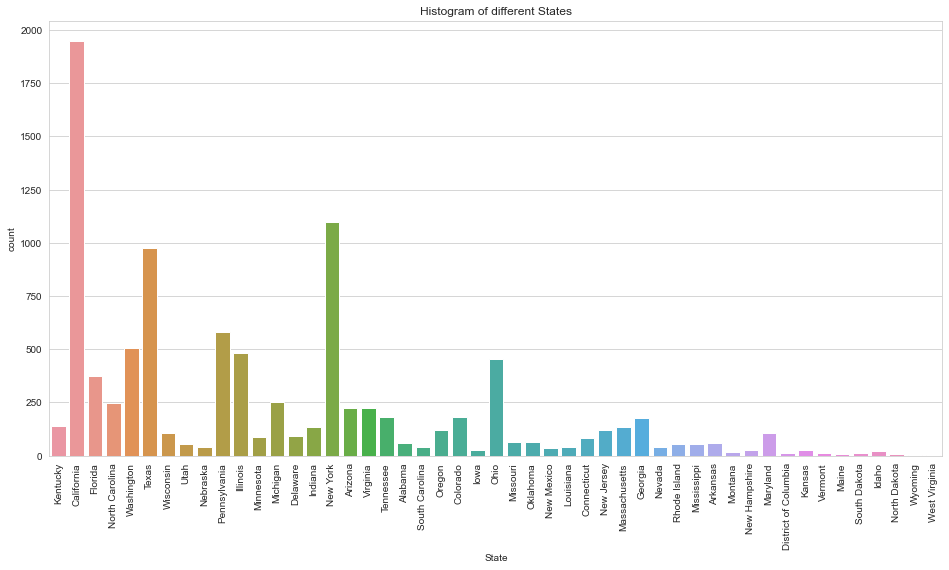

In [110]:
plt.figure(figsize=(16.0, 8.0))
sns.countplot(data=df_changed, x="State")
plt.title("Histogram of different States")
plt.xticks(rotation=90)
plt.show()

In [130]:
from urllib import request

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import descartes

# use geopy to get the coordinates of the cities
geolocator = Nominatim(user_agent="india_explorer")

lat_lon = []
for city in zip(df_changed["City"].to_list()):
    try:
        location = geolocator.geocode(city)
        if location:
            lat_lon.append(location)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed on input {city} with message {e}")
lat_lon

KeyboardInterrupt: 

In [ ]:
df_city_lat_lon = pd.DataFrame(lat_lon, columns=["City", "Coordinates"])
df_city_lat_lon.head()

In [ ]:
import folium

# create map of munich using latitude and longitude values
map_locations = folium.Map(location=[df_city_lat_lon["Coordinates"][0][0], df_city_lat_lon["Coordinates"][0][1]], zoom_start=11)

# add markers to map
for coordinates, district in zip(df_city_lat_lon['Coordinates'], df_city_lat_lon['City']):
    lat, lng = coordinates
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_locations)  
    
map_locations